##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import string

####  <font color=SlateBlue>Google Colab</font>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

####  <font color=SlateBlue>Reading Images</font>

In [ ]:
import os
from PIL import Image

####  <font color=SlateBlue>Preprocessing</font>

In [ ]:
#Tokenizing 
import nltk
nltk.download('punkt')

import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchtext.data import Field, TabularDataset

####  <font color=SlateBlue>CNN</font> ####

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

##  <font color=MediumSlateBlue>Reading Captions and Creating Training and Test Datasets</font> ##

####  <font color=SlateBlue>Captions file is read and turned into a .csv file </font> ####

In [ ]:
#Set the location of your .txt file in as the input
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Deep Learning/HW/3/Captions.txt") 

####  <font color=SlateBlue>Removing punctuations from captions and lower case all words</font> ####

In [ ]:
for punc in string.punctuation+'\n':
  df["caption"] = df.caption.str.replace(punc, " ")
  
df["caption"] = df.caption.str.lower()

####  <font color=SlateBlue>Selecting 90% of data for training dataset and the rest for test dataset</font> ####

In [ ]:
numImg = int(len(df)/5)

trainIndx = random.sample(range(0, numImg), int(0.9*numImg))
trainIndx = [5*i+j for i in trainIndx for j in range(0,5)]

testIndx = [i for i in range(0,numImg) if not i in trainIndx]
testIndx = [5*i+j for i in testIndx for j in range(0,5)]

In [ ]:
trainDF = df.loc[trainIndx, :]
testDF = df.loc[testIndx, :]

####  <font color=SlateBlue>Saving training and test datasets in .csv format for ferthur usage.</font> ####

In [ ]:
trainDF.to_csv(r'Train_Captions.csv', index=False)
testDF.to_csv(r'Test_Captions.csv', index=False)

##  <font color=MediumSlateBlue>Building Vocabulary and Creating Train and Test Datasets and Dataloader</font> ##

####  <font color=SlateBlue>Vocabulary class that can calculate the tokenized represetation of sentences</font> ####

In [ ]:
class Vocabulary():
  def __init__(self, minFreq):
    self.minFreq = minFreq

    self.vocabs = Field(sequential=True, 
                        use_vocab=True, 
                        init_token = '<sos>', 
                        eos_token = '<eos>',
                        tokenize=self.tokenizer, 
                        lower=True)

  def __len__(self): return len(self.vocabs.vocab.stoi)

  def tokenizer(self, text): return nltk.word_tokenize(text)

  def buildVocabulary(self, dataPath, format):
    fields = {'caption': ('c', self.vocabs)}
    dataset = TabularDataset(path=dataPath, format=format, 
                             fields=fields)
    
    self.vocabs.build_vocab(dataset, max_size=10000, min_freq=self.minFreq)

  def numericalize(self, text):
    tokenizedText = self.tokenizer(text)

    return [
        self.vocabs.vocab.stoi[token] 
        if token in self.vocabs.vocab.stoi 
        else self.vocabs.vocab.stoi['<unk>']
        for token in tokenizedText
        ]

####  <font color=SlateBlue>FlickerDataset is a class which reads all images and their captions.</font> ####

In [ ]:
class FlickrDataset(Dataset):
  def __init__(self, imgLoc, captionsLoc, vocabCaption, transform=None, mode='Train'):
    self.imgLoc = imgLoc
    self.transform = transform

    self.df = pd.read_csv(captionsLoc)

    self.imgs = self.df['image']
    self.captions = self.df['caption']

    self.vocabCaption = vocabCaption

    if mode == 'Train':
      self.vocabCaption.buildVocabulary(
          dataPath=captionsLoc, 
          format='csv'
          )

  def __len__(self): return len(self.df)

  def getBuiltVocab(self): return self.vocabCaption

  def __getitem__(self, indx):
    caption = self.captions[indx]

    imgIndx = self.imgs[indx]
    img = Image.open(os.path.join(self.imgLoc, imgIndx)).convert('RGB')

    if self.transform is not None:
      img = self.transform(img)

    numericalizedCaption = [self.vocabCaption.vocabs.vocab.stoi['<sos>']]
    numericalizedCaption.extend(self.vocabCaption.numericalize(caption))
    numericalizedCaption.append(self.vocabCaption.vocabs.vocab.stoi['<eos>'])

    return img, torch.tensor(numericalizedCaption)

####  <font color=SlateBlue>MyCollate is a class which is responsible for padding. </font> ####

In [ ]:
class MyCollate():
  def __init__(self, padIndx):
    self.padIndx = padIndx

  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs, dim=0)

    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, 
                           batch_first=False, 
                           padding_value=self.padIndx)

    return imgs, targets

####  <font color=SlateBlue>Getloader is a function returning a dataloader as well as the created dataset based on the given data</font> ####

In [ ]:
def getLoader(imgLoc, 
              captionsLoc,  
              vocabCaption, 
              transform, 
              mode, 
              batchSize=256, 
              numWorkers=0, 
              shuffle=True, 
              pinMemory=True):
  
  dataset = FlickrDataset(imgLoc, 
                          captionsLoc, 
                          vocabCaption, 
                          transform, 
                          mode)

  padIndx = (dataset.getBuiltVocab()).vocabs.vocab.stoi['<pad>']

  loader = DataLoader(
      dataset=dataset,
      batch_size=batchSize,
      num_workers=numWorkers,
      shuffle=shuffle,
      pin_memory=pinMemory,
      collate_fn=MyCollate(padIndx=padIndx),
  )

  return loader, dataset

####  <font color=SlateBlue>Creating train dataloader and dataset.</font> ####

In [ ]:
transform = T.Compose([T.Resize(300),
                      T.RandomCrop(256),
                      T.ToTensor(),
                      T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainDataLoader, trainDataset = getLoader(
    imgLoc='/content/gdrive/My Drive/Colab Notebooks/Deep Learning/HW/3/Dataset',
    captionsLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Captions/Train_Captions.csv',
    vocabCaption=Vocabulary(5),
    transform=transform,
    mode='Train',
    batchSize=256,
    numWorkers=2
)


####  <font color=SlateBlue>Creating test dataloader and dataset.</font> ####

In [ ]:
testDataLoader, testDataset = getLoader(
    imgLoc='/content/gdrive/My Drive/Colab Notebooks/Deep Learning/HW/3/Dataset',
    captionsLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Captions/Test_Captions.csv',
    vocabCaption=trainDataset.getBuiltVocab(),
    transform=transform,
    mode='Test',
    batchSize=3,
    numWorkers=2
)

##  <font color=MediumSlateBlue>Creating the Neural Network.</font> ##

####  <font color=SlateBlue>Creating the Encoder Module.</font> ####

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embedSize, freezeState):
      super(EncoderCNN, self).__init__()

      resnet = models.resnet18(pretrained=True)

      if not freezeState: 
        for param in resnet.parameters(): param.requires_grad = False

      resnet.fc = nn.Linear(resnet.fc.in_features, embedSize)

      self.encoder = nn.Sequential(
          resnet,
          nn.ReLU(),                                    #ReLU as activation function.
          nn.Dropout(0.5)                              #Dropout for regularization.
      )
          
    def forward(self, imgs):
      return (self.encoder(imgs))

####  <font color=SlateBlue>Creating the Dencoder Module.</font> ####

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self, embedSize, hiddenSize, vocabSize, numLayers):
    super(DecoderRNN, self).__init__()

    self.embed = nn.Embedding(vocabSize, embedSize)
    self.lstm = nn.LSTM(embedSize, hiddenSize, numLayers)
    self.linear = nn.Linear(hiddenSize, vocabSize)
    self.dropout = nn.Dropout(0.5)

  def forward(self, features, captions):
    embeddings = torch.cat((features.unsqueeze(0), self.dropout(self.embed(captions))), dim=0) #Adding a dimension to feature so that it is a sequential figure as well as the embeddings. Than concat them so that the first element is the feature
    hiddens, _ = self.lstm(embeddings)
    return self.linear(hiddens)

####  <font color=SlateBlue>Creating the Connector Module.</font> ####

In [ ]:
class CNNtoRNN(nn.Module):
  def __init__(self, embedSize, hiddenSize, vocabSize, numLayers, freezeState):
    super(CNNtoRNN, self).__init__()

    self.encoder = EncoderCNN(embedSize, freezeState)
    self.decoder = DecoderRNN(embedSize, hiddenSize, vocabSize, numLayers)

  def forward(self, images, captions):
    return self.decoder(self.encoder(images), captions) #Giving the output of encoder which is the features as well as the captions to the decoder

  def captionImage(self, image, vocab, maxLength=50):
    resultCaption = []

    with torch.no_grad():
      x = self.encoder(image).unsqueeze(0) #So that the dimension of the extracted features is as the same as the eements in the batch
      states = None

      for _ in range(maxLength):
        hiddens, states = self.decoder.lstm(x, states)
        output = self.decoder.linear(hiddens.squeeze(0))
        predicted = output.argmax(1)
        resultCaption.append(predicted.item())
        x = self.decoder.embed(predicted).unsqueeze(0)

        if vocab.itos[predicted.item()] == '<eos>':
          break

    caption = [vocab.itos[idx] for idx in resultCaption]
    return ' '.join(caption)

##  <font color=MediumSlateBlue>Training the Neural Network.</font> ##

In [ ]:
def train(trainDataLoader, trainDataset,
          testDataLoader, testDataset,
          embedSize=300, hiddenSize=256, 
          freezeState=True
          ):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  datasetVocab = (trainDataset.getBuiltVocab()).vocabs.vocab

  #Hyperparameters
  vocabSize = len(datasetVocab)
  numLayers = 1
  learningRate = 3e-4
  numEpochs = 30


  #Model creation
  model = CNNtoRNN(embedSize, hiddenSize, vocabSize, numLayers, freezeState).to(device)
  criterion = nn.CrossEntropyLoss(ignore_index=datasetVocab.stoi['<pad>'])
  optimizer = optim.Adam(model.parameters(), lr=learningRate)

  allEpochTrainLoss = []

  for numEpoch in range(numEpochs):
    print('Epoch %d has started......' %(numEpoch+1))
    oneEpochTrainLoss = 0

    print('Training the network......')
    model.train()

    for iteration, (imgs, captions) in enumerate(trainDataLoader):
      imgs = imgs.to(device)
      captions = captions.to(device)

      outputs = model(imgs, captions[:-1])
      loss = criterion(outputs.reshape(-1, outputs.shape[2]), 
                        captions.reshape(-1))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      oneEpochTrainLoss += loss.item()

      #Printing training loss every 20 iterations
      if (iteration+1)%20==0:
        print('Iteration:%d \t Loss:%1.5f' %(iteration+1, oneEpochTrainLoss/(iteration+1)))

    #Printing training loss at the end of each epoch
    print('At the end of epoch %d the average train loss is: %1.5f' %(numEpoch+1, oneEpochTrainLoss/len(trainDataLoader)))
    allEpochTrainLoss.append(oneEpochTrainLoss/len(trainDataLoader))

    #Plotting train loss in every 10 epochs
    if (numEpoch+1)%10==0:
      plt.plot(allEpochTrainLoss, label='Train Loss', color='slateblue')
      plt.title('Loss vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

    print('Testing the network......')
    model.eval()

    with torch.no_grad():
      for imgs, _ in testDataLoader:
        imgs = imgs.to(device)
        for batchIndx in range(imgs.shape[0]):
          output = model.captionImage(imgs[batchIndx,:,:,:].unsqueeze(0), datasetVocab)
          print(output)
          plt.xticks(())
          plt.yticks(())
          plt.imshow(imgs[batchIndx,:,:,:].data.cpu().permute(1, 2, 0))
          plt.show()
          print('...............................................')
        break


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1 has started......
Training the network......
Iteration:20 	 Loss:7.69559
Iteration:40 	 Loss:6.94166
Iteration:60 	 Loss:6.23027
Iteration:80 	 Loss:5.82386
Iteration:100 	 Loss:5.55525
Iteration:120 	 Loss:5.35950
Iteration:140 	 Loss:5.20310
At the end of epoch 1 the average train loss is: 5.18340
Testing the network......
<sos> a man in a man in a <unk> <eos>


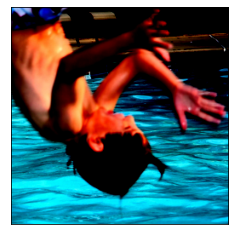

...............................................
<sos> a man in a man in a <unk> <eos>


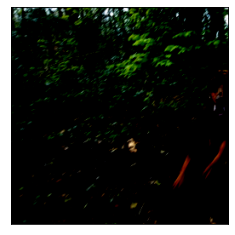

...............................................
<sos> a man in a man in a <unk> <eos>


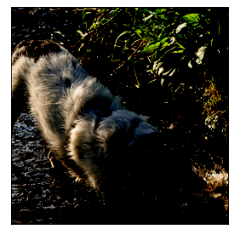

...............................................
Epoch 2 has started......
Training the network......
Iteration:20 	 Loss:4.18057
Iteration:40 	 Loss:4.12857
Iteration:60 	 Loss:4.09193
Iteration:80 	 Loss:4.05985
Iteration:100 	 Loss:4.03325
Iteration:120 	 Loss:4.00628
Iteration:140 	 Loss:3.97944
At the end of epoch 2 the average train loss is: 3.97564
Testing the network......
<sos> a man in a red shirt and a man in a red shirt and a red and white dog is running in the snow <eos>


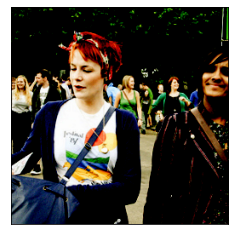

...............................................
<sos> a man in a red shirt and a man in a red shirt and a red and white dog is running in the snow <eos>


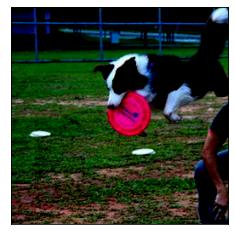

...............................................
<sos> a man in a red shirt and a man in a red shirt and a red and white dog is running in the snow <eos>


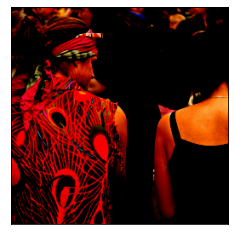

...............................................
Epoch 3 has started......
Training the network......
Iteration:20 	 Loss:3.77005
Iteration:40 	 Loss:3.76030
Iteration:60 	 Loss:3.74400
Iteration:80 	 Loss:3.72795
Iteration:100 	 Loss:3.71370
Iteration:120 	 Loss:3.69817
Iteration:140 	 Loss:3.68834
At the end of epoch 3 the average train loss is: 3.68584
Testing the network......
<sos> a man in a red shirt is standing on a red shirt <eos>


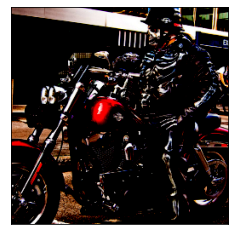

...............................................
<sos> a man in a red shirt is standing on a red shirt <eos>


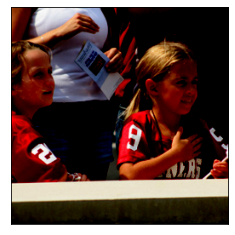

...............................................
<sos> a man in a red shirt is standing on a red shirt <eos>


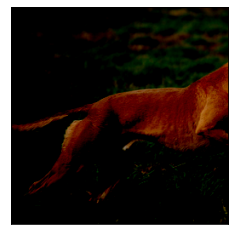

...............................................
Epoch 4 has started......
Training the network......
Iteration:20 	 Loss:3.57193
Iteration:40 	 Loss:3.56416
Iteration:60 	 Loss:3.55402
Iteration:80 	 Loss:3.54183
Iteration:100 	 Loss:3.53859
Iteration:120 	 Loss:3.53050
Iteration:140 	 Loss:3.52052
At the end of epoch 4 the average train loss is: 3.51991
Testing the network......
<sos> a man in a red shirt is standing on a red shirt <eos>


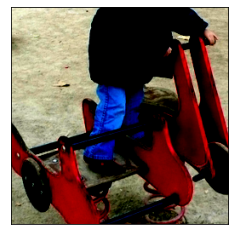

...............................................
<sos> a man in a red shirt is standing on a red shirt <eos>


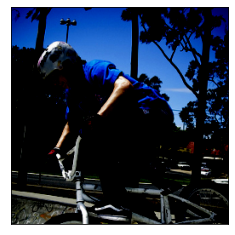

...............................................
<sos> a man in a red shirt is standing on a red shirt <eos>


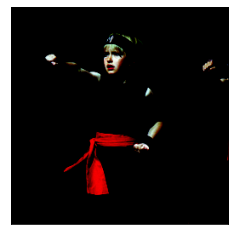

...............................................
Epoch 5 has started......
Training the network......
Iteration:20 	 Loss:3.45187
Iteration:40 	 Loss:3.44266
Iteration:60 	 Loss:3.42862
Iteration:80 	 Loss:3.42468
Iteration:100 	 Loss:3.41463
Iteration:120 	 Loss:3.40794
Iteration:140 	 Loss:3.40157
At the end of epoch 5 the average train loss is: 3.40110
Testing the network......
<sos> a man is standing on a bench <eos>


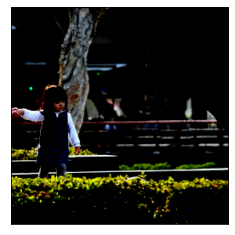

...............................................
<sos> a man is standing on a bench <eos>


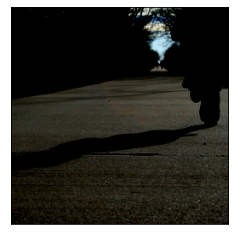

...............................................
<sos> a dog is running through the grass <eos>


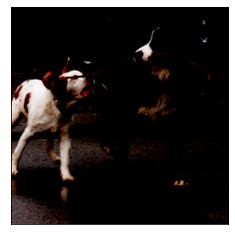

...............................................
Epoch 6 has started......
Training the network......
Iteration:20 	 Loss:3.33394
Iteration:40 	 Loss:3.31602
Iteration:60 	 Loss:3.31111
Iteration:80 	 Loss:3.30559
Iteration:100 	 Loss:3.30662
Iteration:120 	 Loss:3.30056
Iteration:140 	 Loss:3.29603
At the end of epoch 6 the average train loss is: 3.29508
Testing the network......
<sos> a man in a red shirt and a red shirt is standing on a beach <eos>


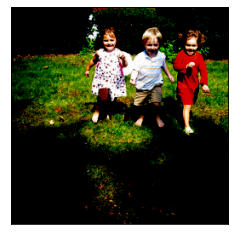

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


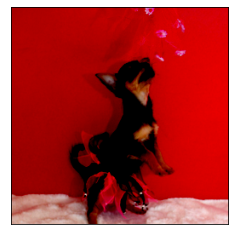

...............................................
<sos> a dog is running through the grass <eos>


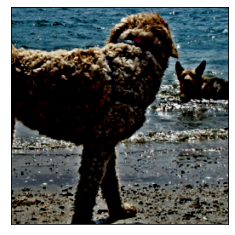

...............................................
Epoch 7 has started......
Training the network......
Iteration:20 	 Loss:3.25278
Iteration:40 	 Loss:3.24460
Iteration:60 	 Loss:3.22832
Iteration:80 	 Loss:3.22364
Iteration:100 	 Loss:3.22203
Iteration:120 	 Loss:3.21958
Iteration:140 	 Loss:3.21243
At the end of epoch 7 the average train loss is: 3.21146
Testing the network......
<sos> a man in a red shirt is standing on a bench <eos>


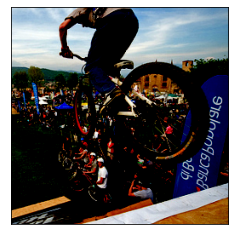

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


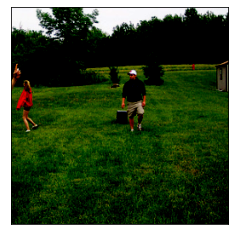

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


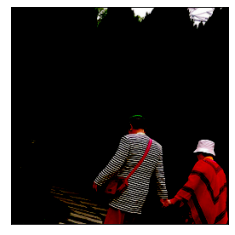

...............................................
Epoch 8 has started......
Training the network......
Iteration:20 	 Loss:3.14867
Iteration:40 	 Loss:3.15707
Iteration:60 	 Loss:3.15103
Iteration:80 	 Loss:3.14783
Iteration:100 	 Loss:3.14815
Iteration:120 	 Loss:3.14666
Iteration:140 	 Loss:3.14255
At the end of epoch 8 the average train loss is: 3.14316
Testing the network......
<sos> a man in a red shirt and a black shirt is standing on a bench <eos>


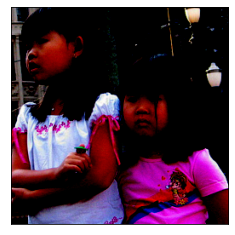

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


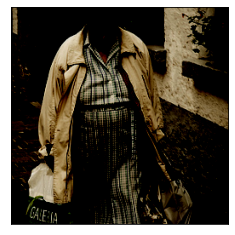

...............................................
<sos> a dog is running through the grass <eos>


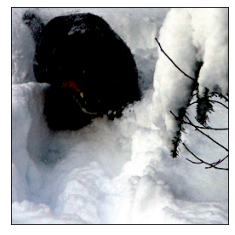

...............................................
Epoch 9 has started......
Training the network......
Iteration:20 	 Loss:3.09289
Iteration:40 	 Loss:3.09061
Iteration:60 	 Loss:3.09354
Iteration:80 	 Loss:3.08964
Iteration:100 	 Loss:3.08859
Iteration:120 	 Loss:3.08745
Iteration:140 	 Loss:3.08469
At the end of epoch 9 the average train loss is: 3.08446
Testing the network......
<sos> a man in a red shirt and a red shirt is standing on a bench <eos>


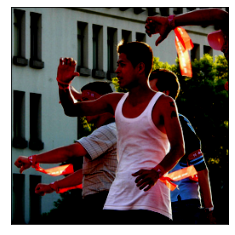

...............................................
<sos> a dog is running through the grass <eos>


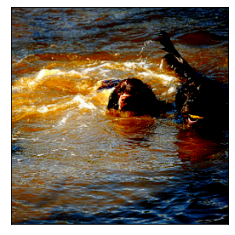

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


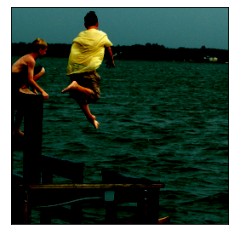

...............................................
Epoch 10 has started......
Training the network......
Iteration:20 	 Loss:3.05596
Iteration:40 	 Loss:3.05032
Iteration:60 	 Loss:3.05285
Iteration:80 	 Loss:3.04760
Iteration:100 	 Loss:3.04380
Iteration:120 	 Loss:3.03360
Iteration:140 	 Loss:3.03135
At the end of epoch 10 the average train loss is: 3.03047


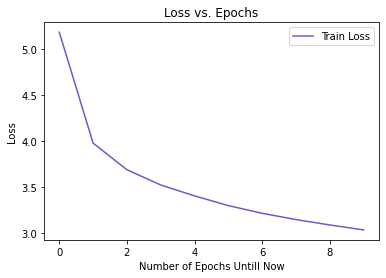

Testing the network......
<sos> a man in a red shirt is standing on a bench <eos>


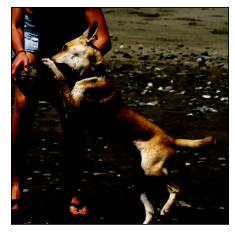

...............................................
<sos> a group of people are standing in front of a <unk> <eos>


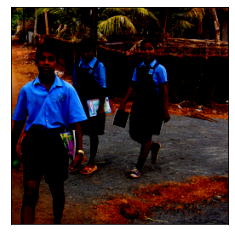

...............................................
<sos> a man in a red shirt and a black shirt is standing on a bench <eos>


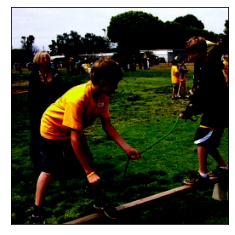

...............................................
Epoch 11 has started......
Training the network......
Iteration:20 	 Loss:3.00144
Iteration:40 	 Loss:2.99991
Iteration:60 	 Loss:2.99799
Iteration:80 	 Loss:2.99420
Iteration:100 	 Loss:2.98924
Iteration:120 	 Loss:2.98755
Iteration:140 	 Loss:2.98499
At the end of epoch 11 the average train loss is: 2.98469
Testing the network......
<sos> a man in a blue shirt is standing on a bench <eos>


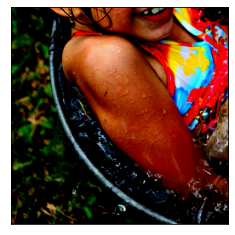

...............................................
<sos> a dog is running through the grass <eos>


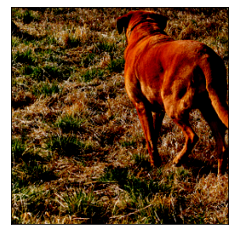

...............................................
<sos> a group of people are sitting on a bench <eos>


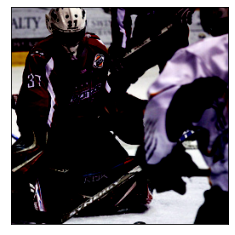

...............................................
Epoch 12 has started......
Training the network......
Iteration:20 	 Loss:2.93475
Iteration:40 	 Loss:2.93482
Iteration:60 	 Loss:2.93129
Iteration:80 	 Loss:2.94130
Iteration:100 	 Loss:2.94121
Iteration:120 	 Loss:2.94253
Iteration:140 	 Loss:2.94104
At the end of epoch 12 the average train loss is: 2.94224
Testing the network......
<sos> a man in a red shirt is standing on a rock wall <eos>


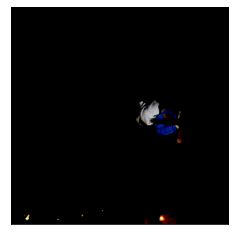

...............................................
<sos> a man in a red shirt is standing on a rock wall <eos>


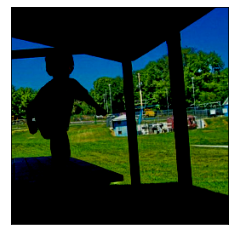

...............................................
<sos> a man in a blue shirt is riding a bike on a skateboard <eos>


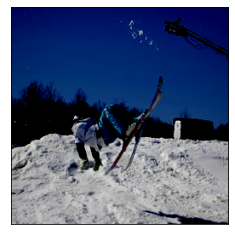

...............................................
Epoch 13 has started......
Training the network......
Iteration:20 	 Loss:2.91152
Iteration:40 	 Loss:2.91380
Iteration:60 	 Loss:2.91115
Iteration:80 	 Loss:2.90889
Iteration:100 	 Loss:2.90622
Iteration:120 	 Loss:2.90585
Iteration:140 	 Loss:2.90274
At the end of epoch 13 the average train loss is: 2.90186
Testing the network......
<sos> a man in a red shirt is standing on a bench <eos>


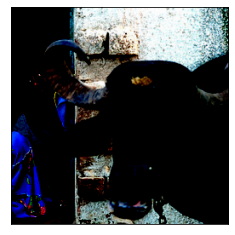

...............................................
<sos> a dog is running through the grass <eos>


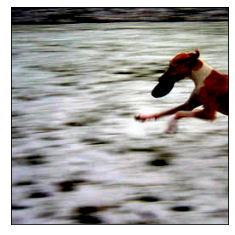

...............................................
<sos> a dog is running through the grass <eos>


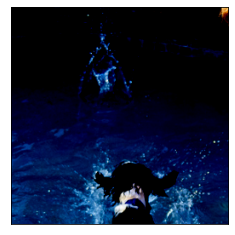

...............................................
Epoch 14 has started......
Training the network......
Iteration:20 	 Loss:2.86958
Iteration:40 	 Loss:2.86745
Iteration:60 	 Loss:2.86538
Iteration:80 	 Loss:2.86611
Iteration:100 	 Loss:2.86489
Iteration:120 	 Loss:2.86466
Iteration:140 	 Loss:2.86486
At the end of epoch 14 the average train loss is: 2.86395
Testing the network......
<sos> a man in a blue shirt is riding a bike on a skateboard <eos>


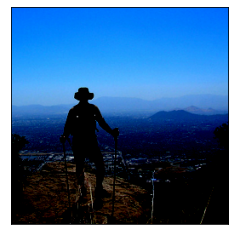

...............................................
<sos> a dog is running through the grass <eos>


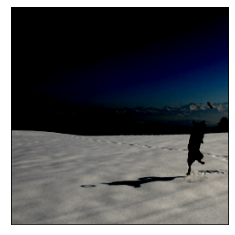

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


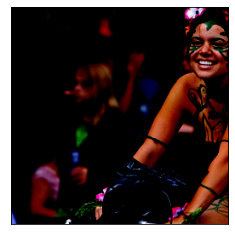

...............................................
Epoch 15 has started......
Training the network......
Iteration:20 	 Loss:2.81510
Iteration:40 	 Loss:2.83228
Iteration:60 	 Loss:2.82412
Iteration:80 	 Loss:2.82880
Iteration:100 	 Loss:2.83137
Iteration:120 	 Loss:2.83019
Iteration:140 	 Loss:2.83044
At the end of epoch 15 the average train loss is: 2.83002
Testing the network......
<sos> a man in a blue shirt is riding a bike on a skateboard <eos>


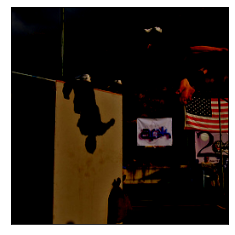

...............................................
<sos> two men are playing in a field <eos>


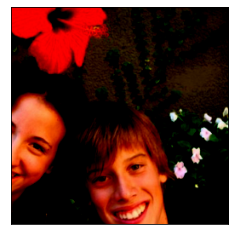

...............................................
<sos> a dog is running through the grass <eos>


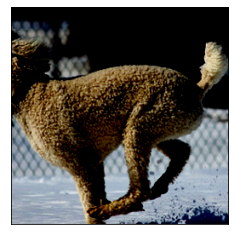

...............................................
Epoch 16 has started......
Training the network......
Iteration:20 	 Loss:2.80643
Iteration:40 	 Loss:2.79766
Iteration:60 	 Loss:2.80771
Iteration:80 	 Loss:2.80579
Iteration:100 	 Loss:2.80663
Iteration:120 	 Loss:2.80136
Iteration:140 	 Loss:2.80033
At the end of epoch 16 the average train loss is: 2.79959
Testing the network......
<sos> two men are playing in a field <eos>


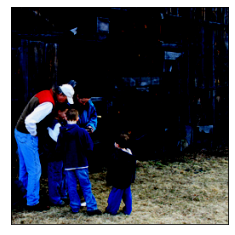

...............................................
<sos> a man in a white shirt and a black shirt is standing in front of a building <eos>


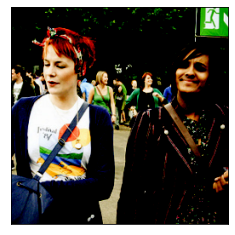

...............................................
<sos> a young boy in a blue shirt is standing in front of a building <eos>


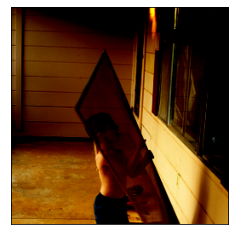

...............................................
Epoch 17 has started......
Training the network......
Iteration:20 	 Loss:2.76806
Iteration:40 	 Loss:2.76989
Iteration:60 	 Loss:2.77003
Iteration:80 	 Loss:2.77164
Iteration:100 	 Loss:2.77290
Iteration:120 	 Loss:2.77156
Iteration:140 	 Loss:2.76970
At the end of epoch 17 the average train loss is: 2.77020
Testing the network......
<sos> a man in a white shirt and a black shirt is standing in front of a building <eos>


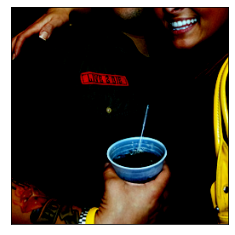

...............................................
<sos> a dog is running through the grass <eos>


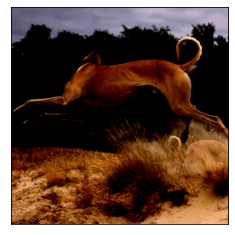

...............................................
<sos> a man in a red shirt and a woman in a red shirt and a black shirt and a woman in a red shirt and a red shirt <eos>


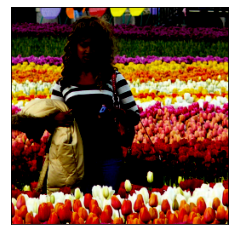

...............................................
Epoch 18 has started......
Training the network......
Iteration:20 	 Loss:2.74425
Iteration:40 	 Loss:2.75099
Iteration:60 	 Loss:2.74714
Iteration:80 	 Loss:2.74748
Iteration:100 	 Loss:2.74358
Iteration:120 	 Loss:2.74366
Iteration:140 	 Loss:2.74249
At the end of epoch 18 the average train loss is: 2.74320
Testing the network......
<sos> two men are playing in a field <eos>


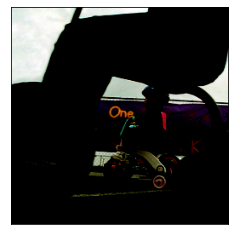

...............................................
<sos> a man in a red shirt is standing on a bench <eos>


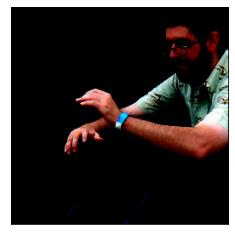

...............................................
<sos> a man in a red shirt is standing in the snow <eos>


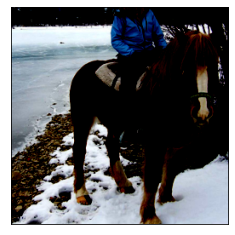

...............................................
Epoch 19 has started......
Training the network......
Iteration:20 	 Loss:2.71598
Iteration:40 	 Loss:2.71234
Iteration:60 	 Loss:2.72042
Iteration:80 	 Loss:2.71557
Iteration:100 	 Loss:2.71951
Iteration:120 	 Loss:2.71964
Iteration:140 	 Loss:2.71752
At the end of epoch 19 the average train loss is: 2.71756
Testing the network......
<sos> a woman in a red shirt and a hat is sitting on a bench <eos>


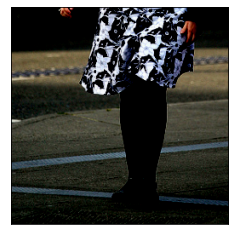

...............................................
<sos> a young boy in a blue shirt is standing on a beach <eos>


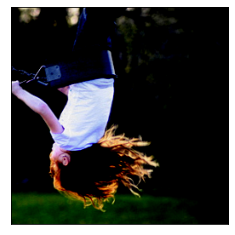

...............................................
<sos> a group of people are sitting on a bench <eos>


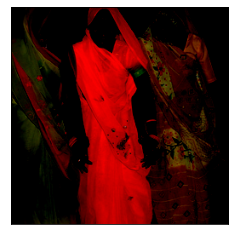

...............................................
Epoch 20 has started......
Training the network......
Iteration:20 	 Loss:2.67988
Iteration:40 	 Loss:2.69034
Iteration:60 	 Loss:2.68838
Iteration:80 	 Loss:2.68946
Iteration:100 	 Loss:2.68793
Iteration:120 	 Loss:2.69139
Iteration:140 	 Loss:2.69106
At the end of epoch 20 the average train loss is: 2.69228


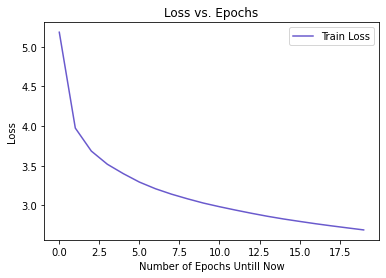

Testing the network......
<sos> a group of people are riding a bike on a dirt road <eos>


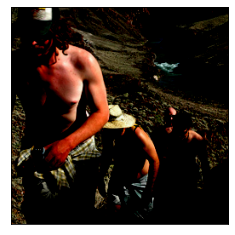

...............................................
<sos> a man in a red shirt is standing in a field of a group of people <eos>


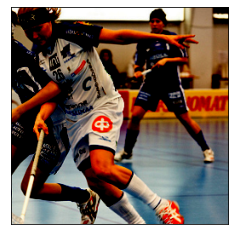

...............................................
<sos> two men in a <unk> <unk> <eos>


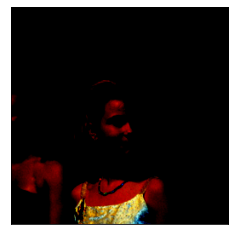

...............................................
Epoch 21 has started......
Training the network......
Iteration:20 	 Loss:2.66845
Iteration:40 	 Loss:2.66045
Iteration:60 	 Loss:2.66594
Iteration:80 	 Loss:2.66758
Iteration:100 	 Loss:2.66739
Iteration:120 	 Loss:2.66746
Iteration:140 	 Loss:2.66868
At the end of epoch 21 the average train loss is: 2.66946
Testing the network......
<sos> a man in a red shirt is running through the grass <eos>


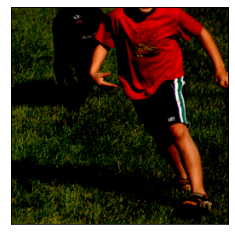

...............................................
<sos> a group of people are walking on a dirt path <eos>


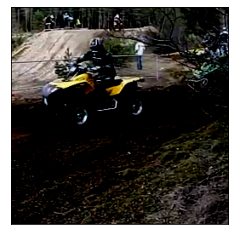

...............................................
<sos> a man in a blue shirt is standing on a rock <eos>


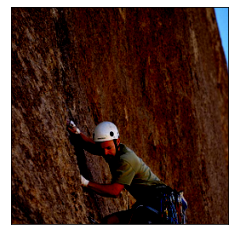

...............................................
Epoch 22 has started......
Training the network......
Iteration:20 	 Loss:2.63621
Iteration:40 	 Loss:2.63884
Iteration:60 	 Loss:2.64603
Iteration:80 	 Loss:2.64680
Iteration:100 	 Loss:2.64726
Iteration:120 	 Loss:2.64415
Iteration:140 	 Loss:2.64559
At the end of epoch 22 the average train loss is: 2.64513
Testing the network......
<sos> two girls are playing in a field <eos>


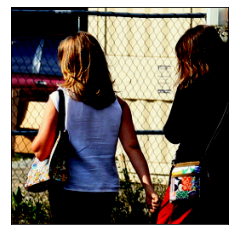

...............................................
<sos> a black and white dog is running through the snow <eos>


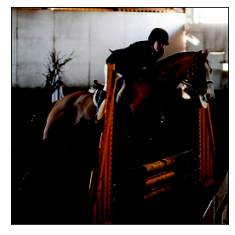

...............................................
<sos> a dog is running through the grass <eos>


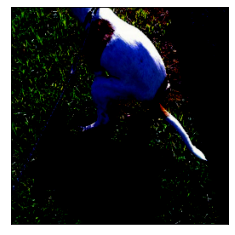

...............................................
Epoch 23 has started......
Training the network......
Iteration:20 	 Loss:2.63296
Iteration:40 	 Loss:2.62617
Iteration:60 	 Loss:2.62960
Iteration:80 	 Loss:2.62477
Iteration:100 	 Loss:2.62549
Iteration:120 	 Loss:2.62410
Iteration:140 	 Loss:2.62411
At the end of epoch 23 the average train loss is: 2.62352
Testing the network......
<sos> two people are standing on a rock overlooking a lake <eos>


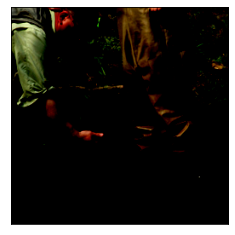

...............................................
<sos> a man in a blue shirt is standing on a rock <eos>


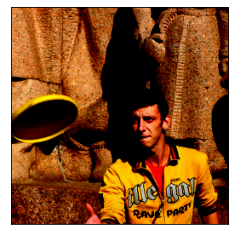

...............................................
<sos> a race car is driving through the air <eos>


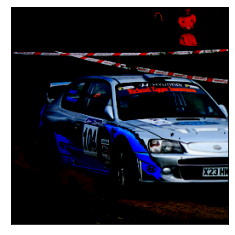

...............................................
Epoch 24 has started......
Training the network......
Iteration:20 	 Loss:2.61471
Iteration:40 	 Loss:2.61098
Iteration:60 	 Loss:2.60682
Iteration:80 	 Loss:2.60418
Iteration:100 	 Loss:2.60237
Iteration:120 	 Loss:2.60168
Iteration:140 	 Loss:2.60381
At the end of epoch 24 the average train loss is: 2.60476
Testing the network......
<sos> two children are playing in a field <eos>


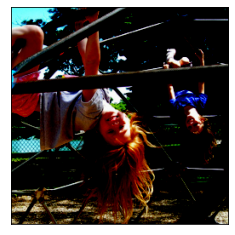

...............................................
<sos> a dog is running through the grass <eos>


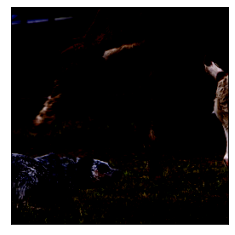

...............................................
<sos> a group of people are standing in a field of a large building <eos>


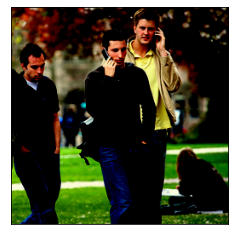

...............................................
Epoch 25 has started......
Training the network......
Iteration:20 	 Loss:2.58633
Iteration:40 	 Loss:2.57345
Iteration:60 	 Loss:2.57433
Iteration:80 	 Loss:2.57484
Iteration:100 	 Loss:2.57842
Iteration:120 	 Loss:2.58045
Iteration:140 	 Loss:2.58179
At the end of epoch 25 the average train loss is: 2.58226
Testing the network......
<sos> a man in a blue shirt is riding a bike on a dirt path <eos>


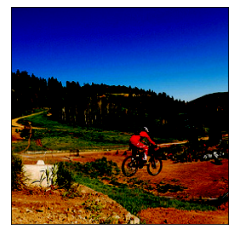

...............................................
<sos> a man in a red jacket is riding a bike on a dirt track <eos>


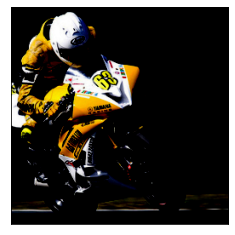

...............................................
<sos> a dog is running through the grass <eos>


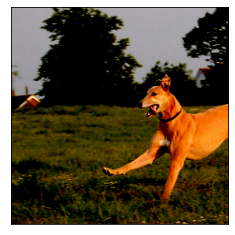

...............................................
Epoch 26 has started......
Training the network......
Iteration:20 	 Loss:2.56519
Iteration:40 	 Loss:2.55946
Iteration:60 	 Loss:2.55673
Iteration:80 	 Loss:2.55808
Iteration:100 	 Loss:2.55997
Iteration:120 	 Loss:2.56127
Iteration:140 	 Loss:2.56333
At the end of epoch 26 the average train loss is: 2.56337
Testing the network......
<sos> a man in a blue shirt is riding a bike on a dirt road <eos>


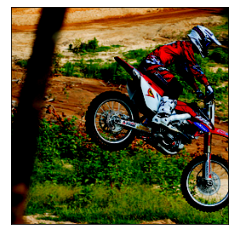

...............................................
<sos> a dog is running through the snow <eos>


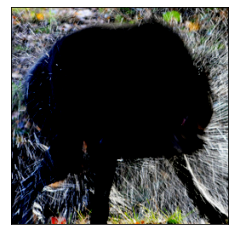

...............................................
<sos> a man in a red shirt is playing a game <eos>


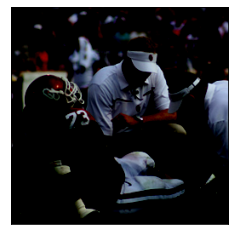

...............................................
Epoch 27 has started......
Training the network......
Iteration:20 	 Loss:2.55756
Iteration:40 	 Loss:2.55297
Iteration:60 	 Loss:2.54728
Iteration:80 	 Loss:2.54183
Iteration:100 	 Loss:2.54055
Iteration:120 	 Loss:2.54180
Iteration:140 	 Loss:2.54499
At the end of epoch 27 the average train loss is: 2.54451
Testing the network......
<sos> a man in a blue shirt is riding a bike in the air <eos>


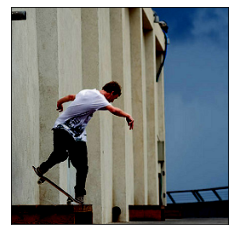

...............................................
<sos> a man in a black shirt and a hat is standing in front of a building <eos>


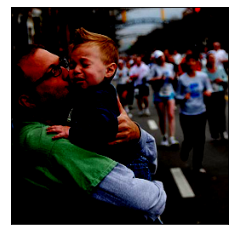

...............................................
<sos> a man in a blue shirt is standing on a rock <eos>


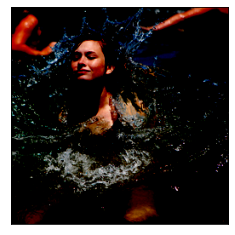

...............................................
Epoch 28 has started......
Training the network......
Iteration:20 	 Loss:2.52207
Iteration:40 	 Loss:2.53288
Iteration:60 	 Loss:2.53088
Iteration:80 	 Loss:2.52696
Iteration:100 	 Loss:2.52875
Iteration:120 	 Loss:2.52590
Iteration:140 	 Loss:2.52777
At the end of epoch 28 the average train loss is: 2.52763
Testing the network......
<sos> two dogs are running through the snow <eos>


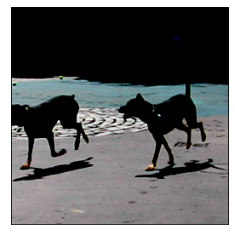

...............................................
<sos> two dogs are running through the snow <eos>


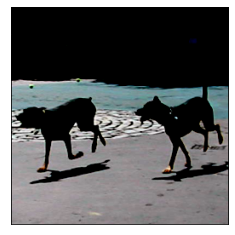

...............................................
<sos> a man in a blue shirt is standing on a rock <eos>


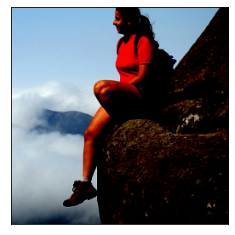

...............................................
Epoch 29 has started......
Training the network......
Iteration:20 	 Loss:2.51171
Iteration:40 	 Loss:2.50637
Iteration:60 	 Loss:2.50539
Iteration:80 	 Loss:2.50642
Iteration:100 	 Loss:2.50968
Iteration:120 	 Loss:2.51085
Iteration:140 	 Loss:2.51081
At the end of epoch 29 the average train loss is: 2.51132
Testing the network......
<sos> a group of people are riding a bike on a dirt track <eos>


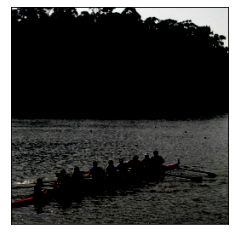

...............................................
<sos> a woman in a red shirt is standing in front of a crowd of people <eos>


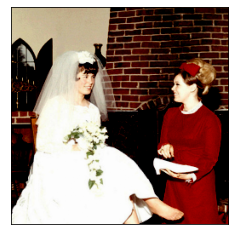

...............................................
<sos> a dog is running through the snow <eos>


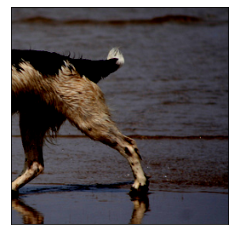

...............................................
Epoch 30 has started......
Training the network......
Iteration:20 	 Loss:2.49719
Iteration:40 	 Loss:2.49211
Iteration:60 	 Loss:2.49427
Iteration:80 	 Loss:2.49624
Iteration:100 	 Loss:2.49954
Iteration:120 	 Loss:2.49775
Iteration:140 	 Loss:2.49696
At the end of epoch 30 the average train loss is: 2.49655


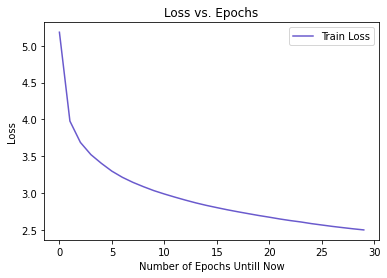

Testing the network......
<sos> two children are playing in the water <eos>


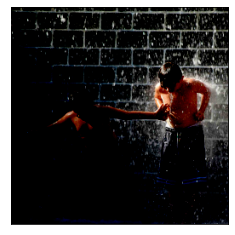

...............................................
<sos> a woman in a blue shirt and a backpack is standing on a rock <eos>


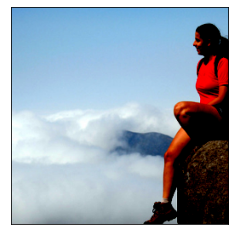

...............................................
<sos> two people are riding a bicycle on a dirt track <eos>


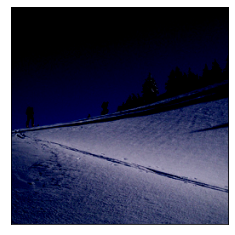

...............................................


In [ ]:
train(trainDataLoader, trainDataset, testDataLoader, testDataset)